In [1]:
import clip
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from PIL import Image

clip.available_models()

['RN50',
 'RN101',
 'RN50x4',
 'RN50x16',
 'RN50x64',
 'ViT-B/32',
 'ViT-B/16',
 'ViT-L/14',
 'ViT-L/14@336px']

## Loading the model

In [2]:
model, preprocess = clip.load("ViT-B/32")
model.eval()

input_resolution = model.visual.input_resolution
context_length = model.context_length
vocab_size = model.vocab_size

print("Model parameters:", f"{np.sum([int(np.prod(p.shape)) for p in model.parameters()]):,}")
print("Input resolution:", input_resolution)
print("Context length:", context_length)
print("Vocab size:", vocab_size)

Model parameters: 151,277,313
Input resolution: 224
Context length: 77
Vocab size: 49408


## Image preprocessing

In [3]:
preprocess

Compose(
    Resize(size=224, interpolation=bicubic, max_size=None, antialias=True)
    CenterCrop(size=(224, 224))
    <function _convert_image_to_rgb at 0x10b16dc10>
    ToTensor()
    Normalize(mean=(0.48145466, 0.4578275, 0.40821073), std=(0.26862954, 0.26130258, 0.27577711))
)

## Text preprocessing

In [4]:
tensor = clip.tokenize("Hello World!")
print(tensor)

tensor([[49406,  3306,  1002,   256, 49407,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0]], dtype=torch.int32)


## Setting-up the input for zero-shot radiology report retrieval

In [22]:
DATA_PATH = '/Volumes/T7 Shield/datasets/iu-xray'

reports = pd.read_csv(f'{DATA_PATH}/indiana_reports.csv')
projections = pd.read_csv(f'{DATA_PATH}/indiana_projections.csv')

reports['findings'].fillna('')
reports['impression'].fillna('')

reports_sample = reports.sample(n=5)

subset = {}

for index, report in reports_sample.iterrows():
    uid = report['uid']
    text = str(report['impression'])

    frontal_projection = projections[(projections['uid'] == uid) & (projections['projection'] == 'Frontal')]
    if not frontal_projection.empty:
        image_name = frontal_projection.iloc[0]['filename']

        subset[uid] = {
            'report': text,
            'image_filename': image_name
        }

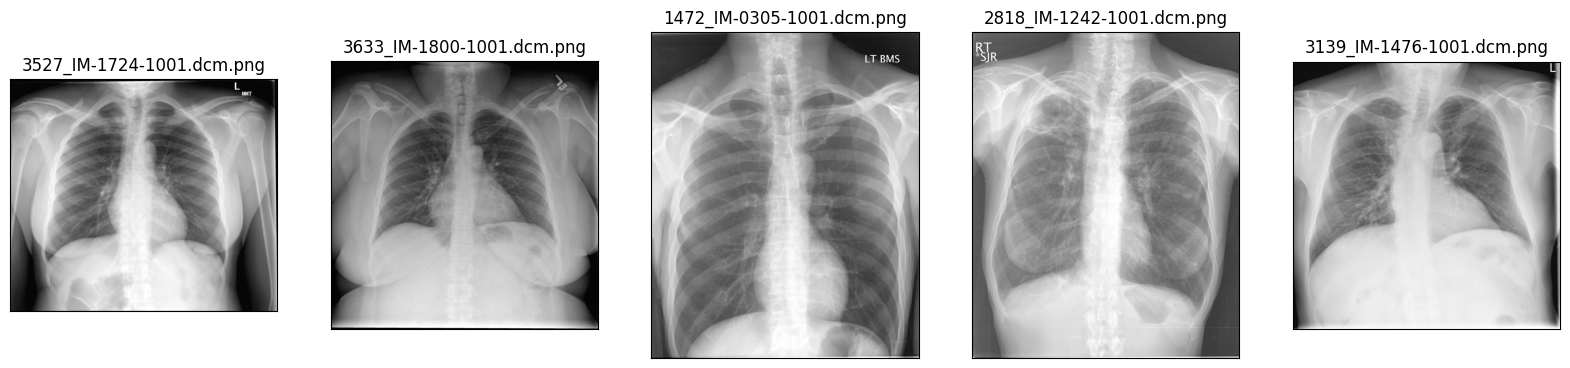

In [23]:
plt.figure(figsize=(20, 20))

for i, (uid, entry) in enumerate(subset.items(), 1):
    report = entry['report']
    image_filename = entry['image_filename']

    image_path = f'{DATA_PATH}/images/images_normalized/{image_filename}'
    image = Image.open(image_path).convert('RGB')

    plt.subplot(2, 5, i)
    plt.imshow(image)
    plt.title(image_filename)
    plt.xticks([])
    plt.yticks([])

In [28]:
original_images = []
images = []
texts = []
for (uid, entry) in subset.items():
    image = Image.open(f'{DATA_PATH}/images/images_normalized/{entry["image_filename"]}').convert('RGB')
    original_images.append(image)
    images.append(preprocess(image))
    texts.append(entry['report'])

image_input = torch.tensor(np.stack(images))
text_tokens = clip.tokenize(texts)

with torch.no_grad():
    image_features = model.encode_image(image_input).float()
    text_features = model.encode_text(text_tokens).float()

Text(0.5, 1.0, 'Cosine similarity between text and image features')

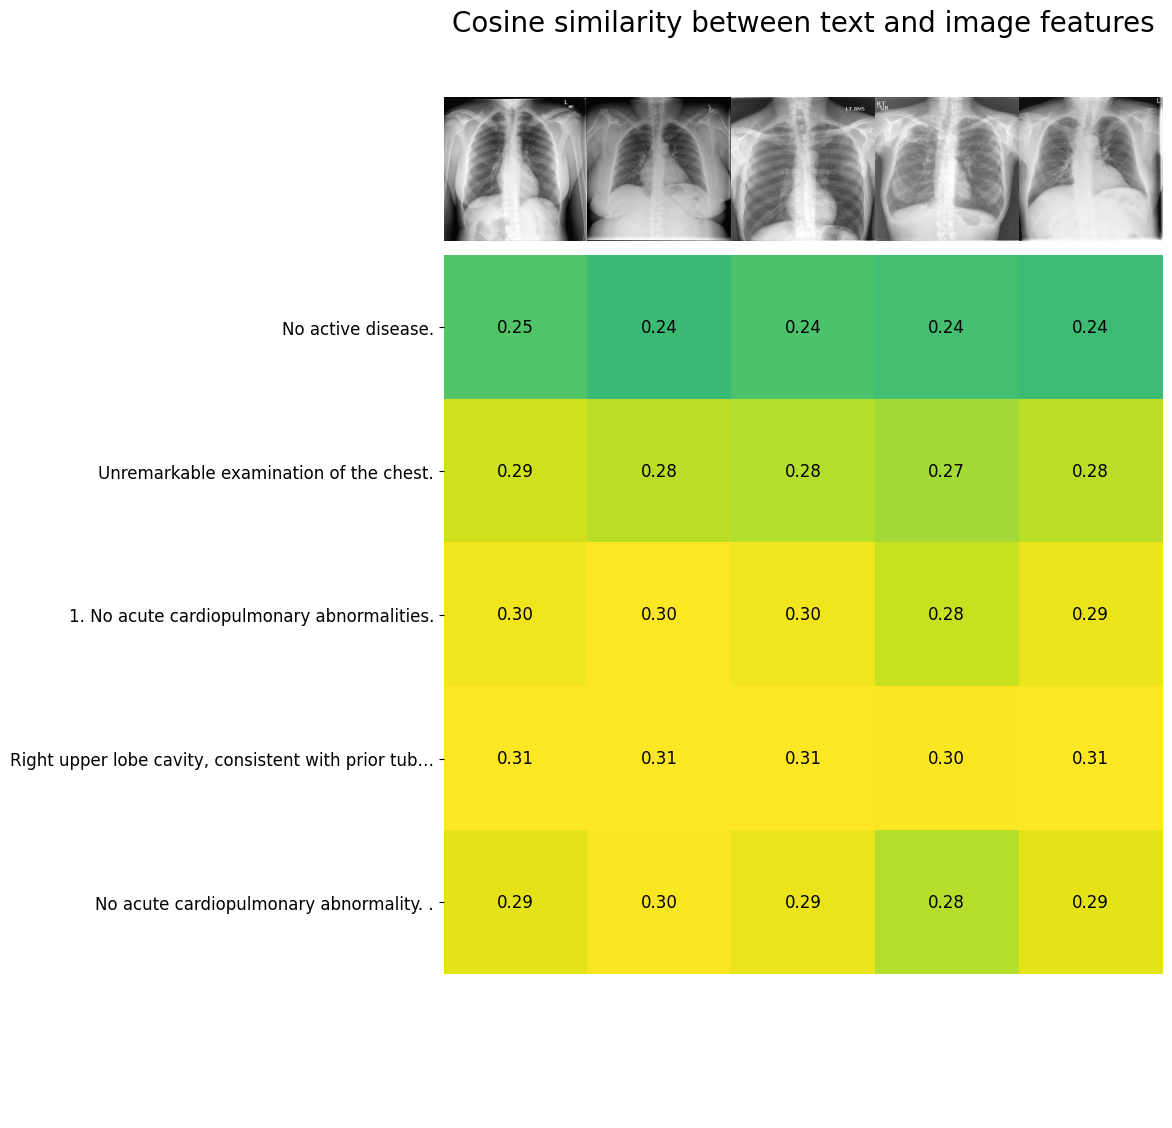

In [35]:
image_features /= image_features.norm(dim=-1, keepdim=True)
text_features /= text_features.norm(dim=-1, keepdim=True)
similarity = text_features.cpu().numpy() @ image_features.cpu().numpy().T

count = len(texts)

plt.figure(figsize=(20, 14))
plt.imshow(similarity, vmin=0.1, vmax=0.3)

max_length = 50
truncated_texts = [t[:max_length] + "…" if len(t) > max_length else t for t in texts]
plt.yticks(range(count), truncated_texts, size=12)
plt.xticks([])

for i, image in enumerate(original_images):
    plt.imshow(image, extent=(i - 0.5, i + 0.5, -1.6, -0.6), origin='lower')
for x in range(similarity.shape[1]):
    for y in range(similarity.shape[0]):
        plt.text(x, y, f'{similarity[y, x]:.2f}', ha='center', va='center', size=12)

for side in ['top', 'right', 'bottom', 'left']:
    plt.gca().spines[side].set_visible(False)

plt.xlim([-0.5, count - 0.5])
plt.ylim([count + 0.5, -2])

plt.title('Cosine similarity between text and image features', size=20)